# V4: evaluation frame work

In [1]:
import matplotlib.pyplot as plt
import torch

In [19]:
import numpy as np

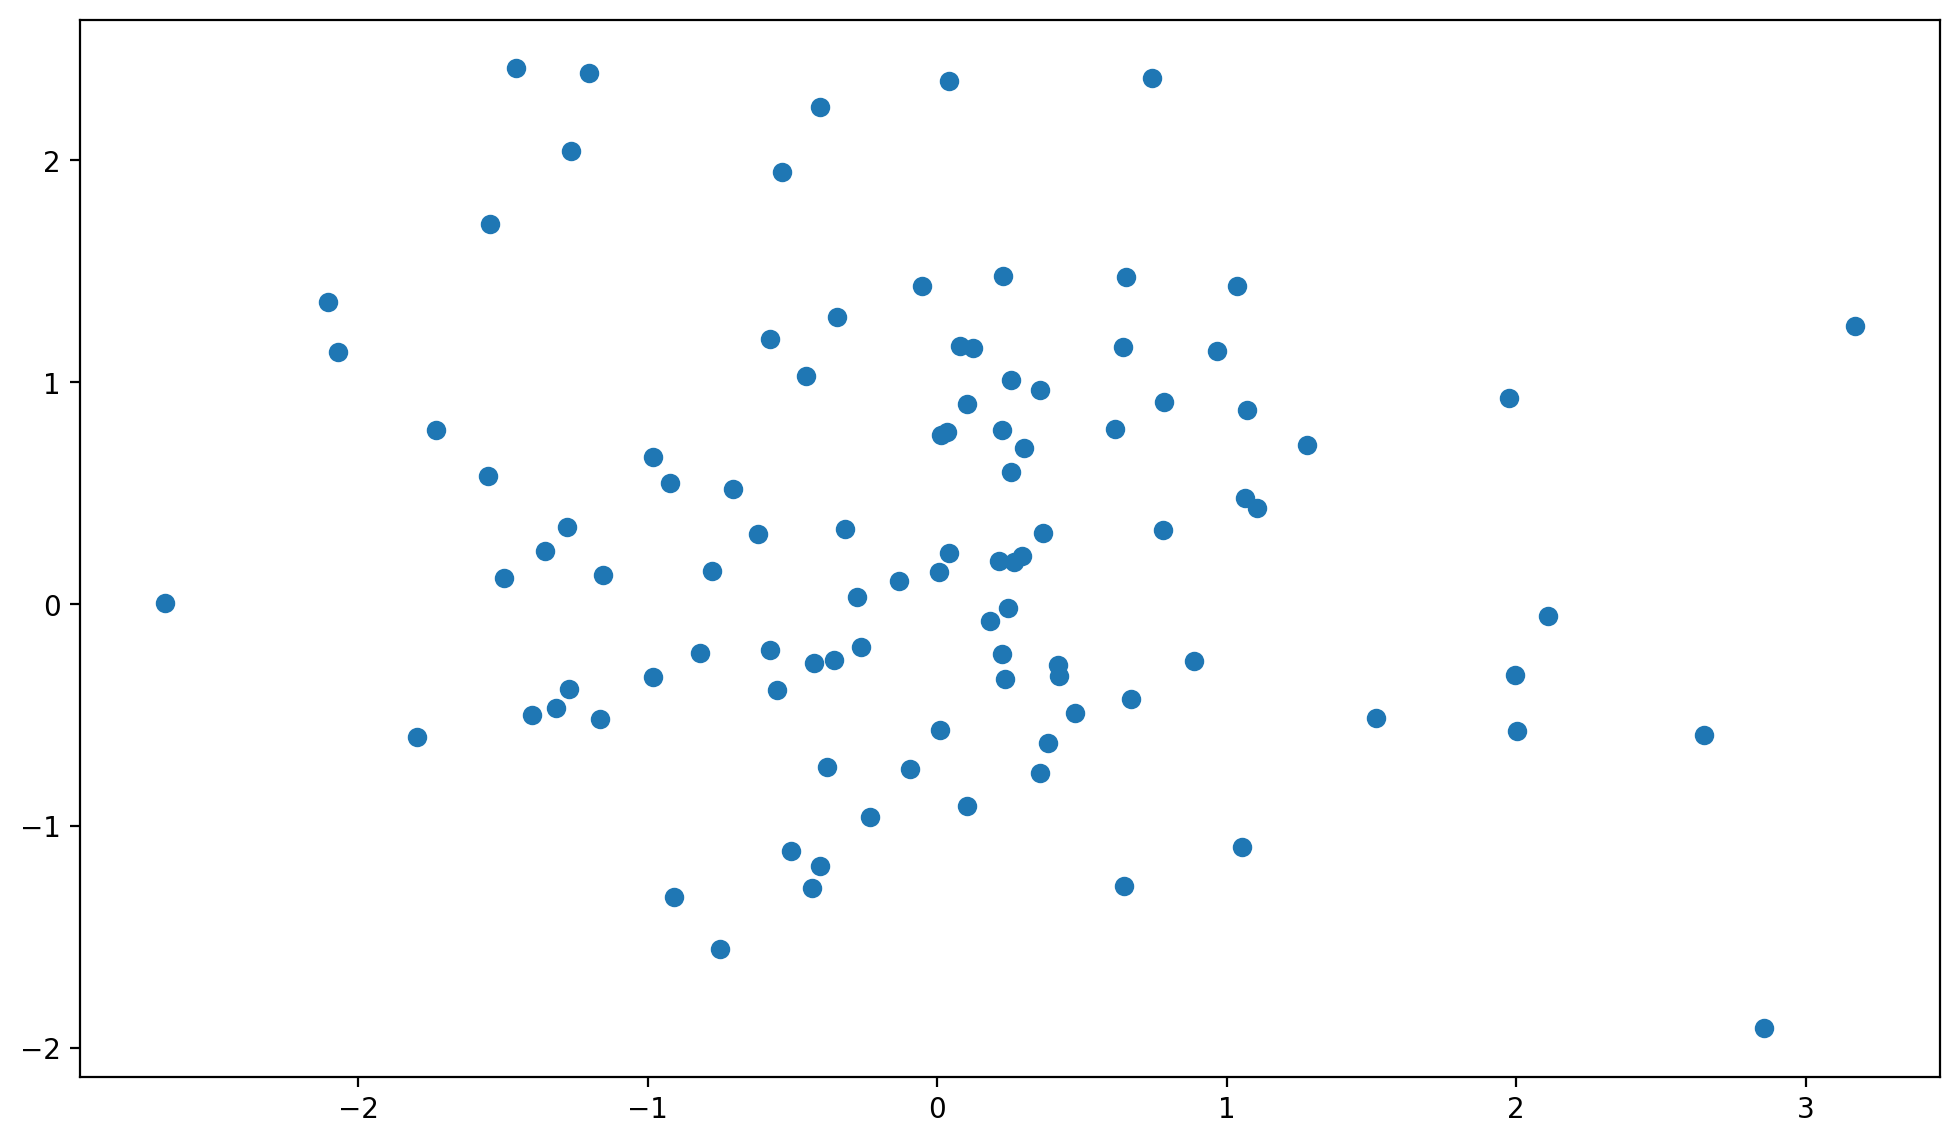

In [23]:
plt.figure(figsize=(12,7),dpi=200)
plt.scatter(np.random.normal(0,1,100),np.random.normal(0,1,100))

In [11]:
def target_function1(x):
    return torch.exp(-x*4)*torch.cos(x*20)
def get_data(fn,N):
    x = torch.rand(N)
    y = fn(x)
    return x,y
def choice(x,y,N): # (num_train,1),(num_train,1),int
    idx = torch.randint(0,x.size(0),(N,))
    return x[idx],y[idx] # (N,1)
def nm(x):
    if 'cpu' in x.device.type:
        return x.detach().numpy()
    else:
        return x.detach().cpu().numpy()

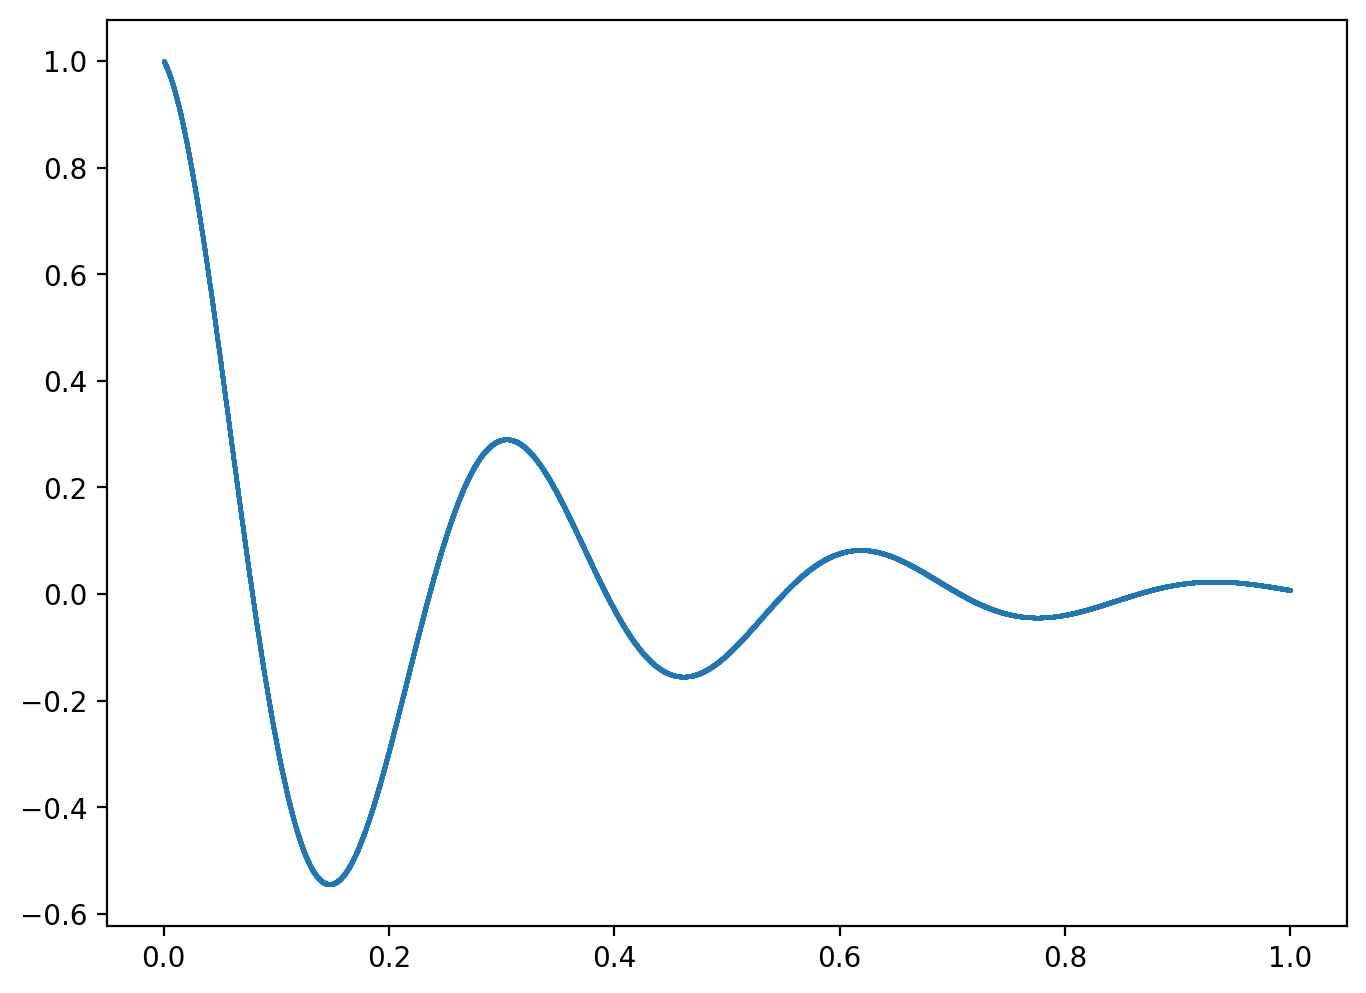

In [17]:
plt.figure(figsize=(8,6),dpi=200)
x = torch.rand(1000)
x = torch.linspace(0,1,10000)
y = target_function1(x)
plt.scatter(nm(x),nm(y),s=0.5)

## two layer res net is best model in 10 sec

In [4]:
import torch.nn as nn
class TwoLayerNetRes(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(TwoLayerNetRes, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.linear3 = torch.nn.Linear(H, D_out)
    def forward(self,x):
        h_relu1 = self.linear1(x).clamp(min=0)
        h_relu2 = self.linear2(h_relu1).clamp(min=0)
        y_pred = self.linear3(h_relu2+h_relu1)
        return y_pred

In [5]:
import pickle
import time

## find best by optuna = Res4layer(600x600)
- try to predict

In [6]:
import time

In [13]:
MAX_ITR = 1000000
MAX_TIME = 10 # [sec]
H = 600 
b_size = 128
device = torch.device("cuda:2")

model = TwoLayerNetRes(1,H,1).to(device)
optim = torch.optim.Adadelta(model.parameters())
x = x.to(device)
y = y.to(device)
log = []
st = time.time()
for i in range(MAX_ITR):
    xx,yy = choice(x,y,b_size)
    y_ = yy.unsqueeze(-1)
    y_pred = model(xx.unsqueeze(-1))
    loss =torch.pow(y_pred-y_,2).mean()
    optim.zero_grad()
    loss.backward()
    optim.step()
    # print(loss.item())
    log.append(loss.item())
    if time.time() - st > MAX_TIME:
        break

In [14]:
import  numpy as np

## check model param

In [15]:
for parameter in model.parameters():
    print(parameter.shape)

torch.Size([600, 1])
torch.Size([600])
torch.Size([600, 600])
torch.Size([600])
torch.Size([1, 600])
torch.Size([1])


0.00030773234902881086

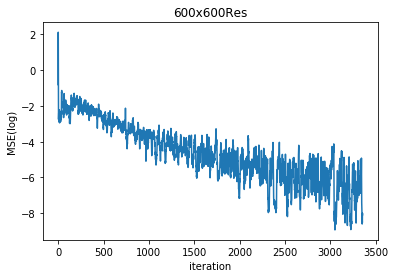

In [16]:
plt.plot(np.log(log))
plt.title('600x600Res')
plt.ylabel('MSE(log)')
plt.xlabel('iteration')
log[-1]

Text(0.5, 1.0, '600x600Res')

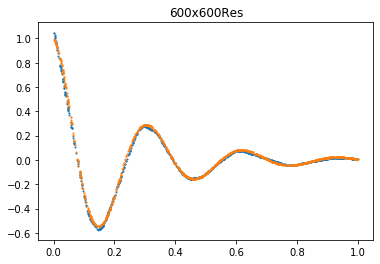

In [17]:
y_pred = model(x.unsqueeze(-1))
plt.scatter(nm(x),nm(y_pred),s=1)
plt.scatter(nm(x),nm(y),s=1)
plt.title('600x600Res')

# make practical model

In [7]:
import pickle

In [8]:
class AbstModel(object):
    def __init__(self,device):
        self.device = device
        self.name = 'abst2_model'
        
    def pred_mean(self,x): # (10000)
        return torch.randn(x.shape[0]).to(self.device) # (10000)
    
    def pred_unce(self,x): # (10000)
        return torch.randn(x.shape[0]).to(self.device) # (10000)
    
    def learn(self,x,y): # x:(itr,1), y:(itr,1)   
        # learn in 10 sec
        pass

def eval_model(model):
    x,y = get_data(target_function1,100000)
    x = x.to(model.device)
    y = y.to(model.device)
    y_pred = model.pred_mean(x)
    return torch.pow(y - y_pred,2).mean()

def make_log(save_name,eva,train_x,train_y,model):
    log = {}
    log['eval'] = eva
    log['train_x'] = nm(train_x)
    log['train_y'] = nm(train_y)
    log['all_x'] = nm(torch.linspace(0, 1, steps=10000))
    log['all_y'] = nm(target_function1(torch.linspace(0, 1, steps=10000)))
    log['all_y_mean'] = nm(model.pred_mean(torch.linspace(0, 1, steps=10000).to(model.device)))
    log['all_y_unce'] = nm(model.pred_unce(torch.linspace(0, 1, steps=10000).to(model.device)))
    with open(save_name,mode='wb') as f:
        pickle.dump(log,f)

def draw(load_name,save_name):
    with open(load_name,mode='rb') as f:
        load_log = pickle.load(f)
    fig, ax = plt.subplots(1, 2, figsize=(13, 5),dpi=100)
    fig.suptitle(load_name)
    ax[0].plot(load_log['eval'])
    ax[0].set_xlabel('Number of data collected')
    ax[0].set_ylabel('MSE over 100k samples')
    ax[1].plot(load_log['all_x'],load_log['all_y_mean'],label='prediction_mean',color='red',lw=1)
    ax[1].fill_between(load_log['all_x'],load_log['all_y_mean']-load_log['all_y_unce'],
                       load_log['all_y_mean']+load_log['all_y_unce'],label='prediction_unce',color='pink',alpha=0.6)
    ax[1].scatter(load_log['train_x'],load_log['train_y'],label='train data',color='blue',s=2,zorder=100)
    ax[1].legend()
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    plt.savefig(save_name,dpi=100,format = 'png')

## Evaluation Framework

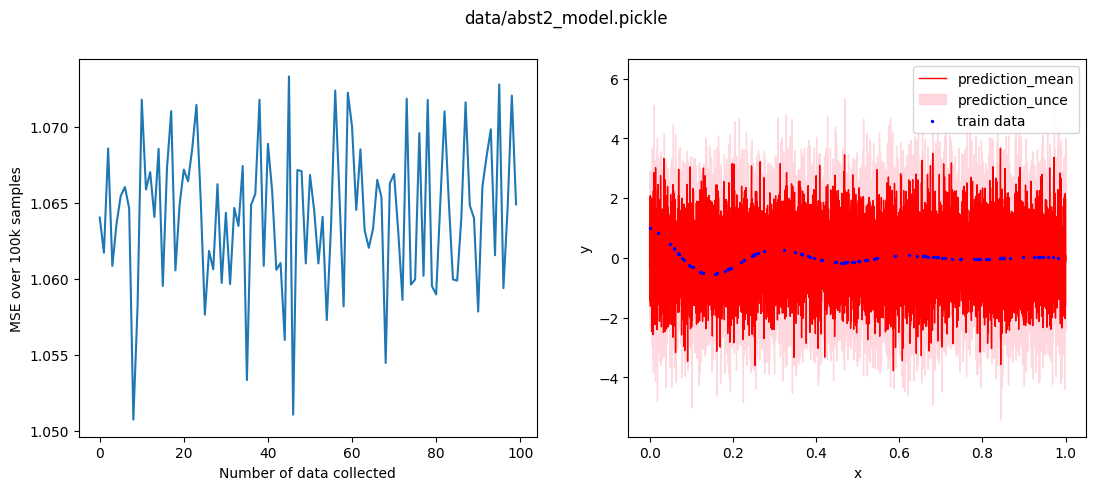

In [14]:
cand = 10000
device = torch.device("cuda:2")
model = AbstModel(device)
eva = []
for i in range(100):
    x,y = get_data(target_function1,cand)
    max_id = model.pred_unce(x).argmax()
    if i ==0:
        train_x = x[max_id].view(1,1)
        train_y = y[max_id].view(1,1)
    else:
        train_x = torch.cat((train_x,x[max_id].view(1,1)))
        train_y = torch.cat((train_y,y[max_id].view(1,1)))
    model.learn(train_x,train_y)
    
    eva.append(eval_model(model))
save_name = 'data/'+model.name+'.pickle'
make_log(save_name,eva,train_x,train_y,model)
draw('data/'+model.name+'.pickle','data/'+model.name+'.png')

# V4_exp1:base line

In [70]:
MAX_TIME=10
MAX_ITR = 1000000
class RandomChoice(AbstModel):
    def __init__(self,device,H=600,b_size=128):
        super().__init__(device)
        self.H = H
        self.b_size = b_size
        self.name = 'random'
        self.model = TwoLayerNetRes(1,H,1).to(self.device)
        self.optim = torch.optim.Adadelta(self.model.parameters())
        
    def pred_mean(self,x): # (10000)
        return self.model(x.unsqueeze(-1)).squeeze(1).detach() # (10000)

    def learn(self,x,y):
        st = time.time()
        for i in range(MAX_ITR):
            xx,yy = choice(x,y,self.b_size)
            y_ = yy.unsqueeze(-1)
            y_pred = self.model(xx.unsqueeze(-1))
            loss =torch.pow(y_pred-y_,2).mean()
            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
            if time.time() - st > MAX_TIME:
                break

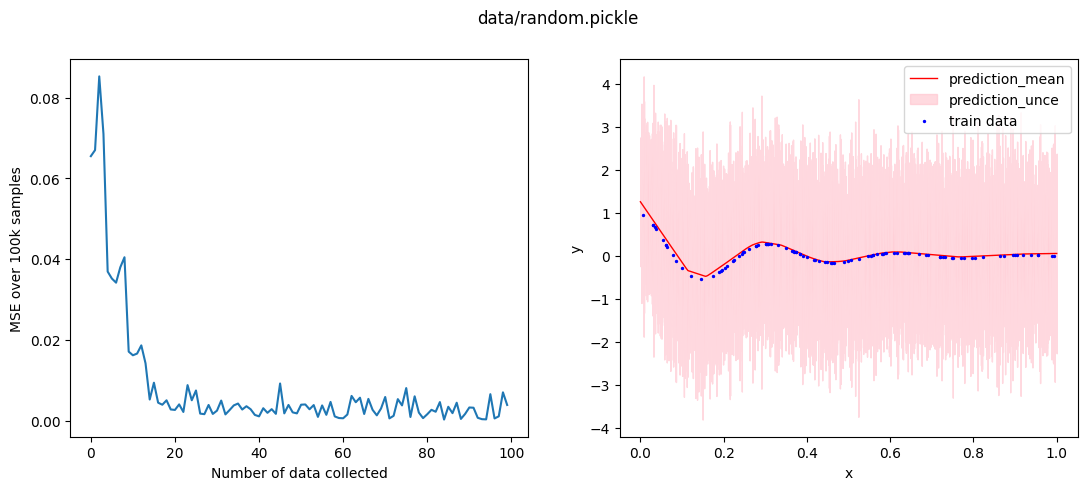

In [71]:
cand = 10000
device = torch.device("cuda:2")
model = RandomChoice(device)
eva = []
for i in range(100):
    x,y = get_data(target_function1,cand)
    x = x.to(device)
    y = y.to(device)
    max_id = model.pred_unce(x).argmax()
    if i ==0:
        train_x = x[max_id].view(1,1)
        train_y = y[max_id].view(1,1)
    else:
        train_x = torch.cat((train_x,x[max_id].view(1,1)))
        train_y = torch.cat((train_y,y[max_id].view(1,1)))
    model = RandomChoice(device)
    model.learn(train_x,train_y)
    eva.append(eval_model(model))
save_name = 'data/'+model.name+'.pickle'
make_log(save_name,eva,train_x,train_y,model)
draw('data/'+model.name+'.pickle','data/'+model.name+'.png')

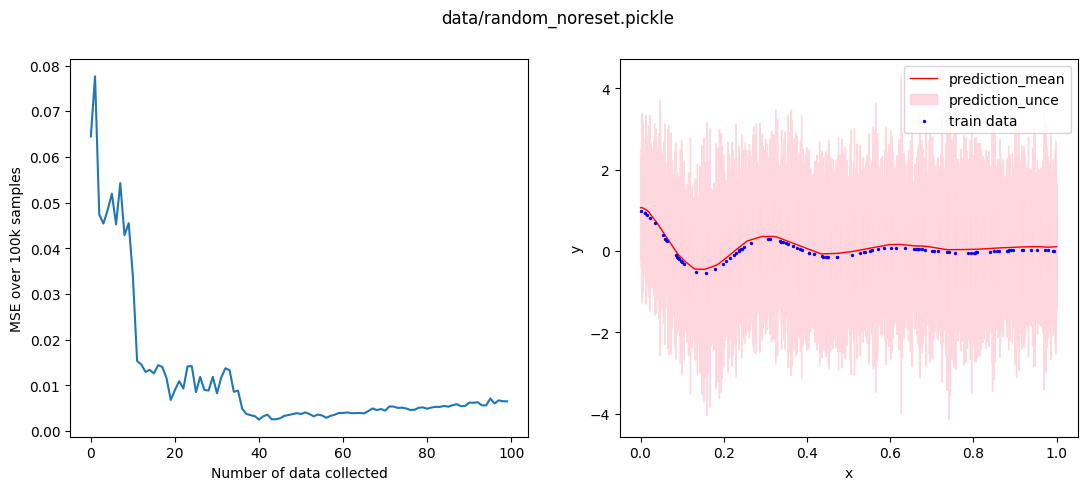

In [33]:
cand = 10000
device = torch.device("cuda:2")
model = RandomChoice(device)
eva = []
for i in range(100):
    x,y = get_data(target_function1,cand)
    x = x.to(device)
    y = y.to(device)
    max_id = model.pred_unce(x).argmax()
    if i ==0:
        train_x = x[max_id].view(1,1)
        train_y = y[max_id].view(1,1)
    else:
        train_x = torch.cat((train_x,x[max_id].view(1,1)))
        train_y = torch.cat((train_y,y[max_id].view(1,1)))
    # model = RandomChoice(device)
    model.learn(train_x,train_y)
    eva.append(eval_model(model))
save_name = 'data/'+model.name+'_noreset.pickle'
make_log(save_name,eva,train_x,train_y,model)
draw('data/'+model.name+'_noreset.pickle','data/'+model.name+'_noreset'+'.png')

# EquallySpacedChoice in x
- remeber all train x and chose farest one
- itr==0 chose left and itr==1 chose right
- demelit : neighbor search need a lot of time

In [73]:
MAX_TIME=10
MAX_ITR = 1000000
class EquallySpacedChoice(AbstModel):
    def __init__(self,device,H=600,b_size=128):
        super().__init__(device)
        self.H = H
        self.b_size = b_size
        self.name = 'equally_x'
        self.model = TwoLayerNetRes(1,H,1).to(self.device)
        self.optim = torch.optim.Adadelta(self.model.parameters())
        
    def pred_mean(self,x): # (10000)
        return self.model(x.unsqueeze(-1)).squeeze(1).detach() # (10000)

    def pred_unce(self,x):# (10000)
        if hasattr(self,'train_x'):
            ret = torch.zeros(x.shape)
            for i,xx in enumerate(x):
                ret[i] = (self.train_x - xx).abs().min()
            return ret
        else:
            min_id = x.argmin()
            ret = torch.zeros(x.shape)
            ret[min_id]=1.0
            return  ret

    def learn(self,x,y):# (itr,1), (itr,1)
        st = time.time()
        for i in range(MAX_ITR):
            xx,yy = choice(x,y,self.b_size)
            y_ = yy.unsqueeze(-1)
            y_pred = self.model(xx.unsqueeze(-1))
            loss =torch.pow(y_pred-y_,2).mean()
            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
            if time.time() - st > MAX_TIME:
                break
        self.train_x = x

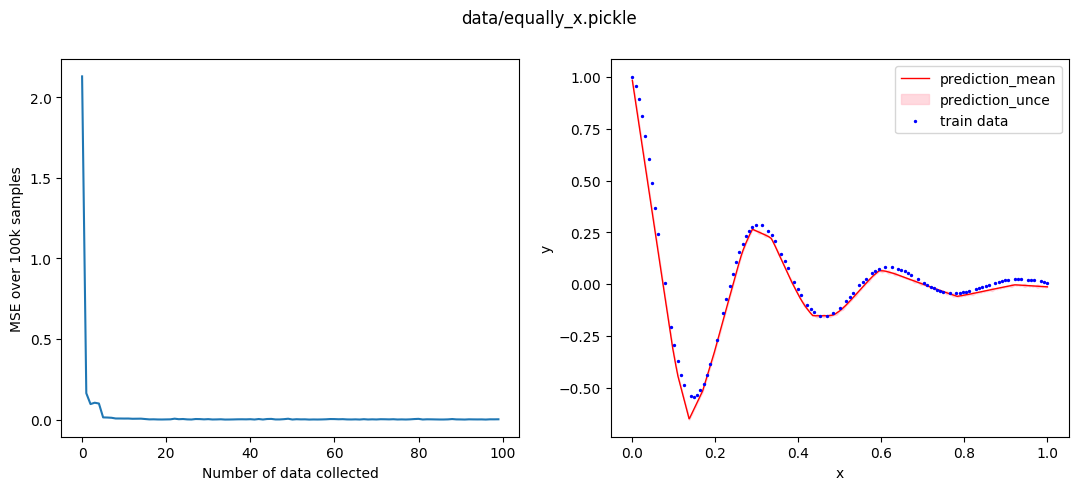

In [74]:
cand = 10000
device = torch.device("cuda:2")
model = EquallySpacedChoice(device)
eva = []
for i in range(100):
    x,y = get_data(target_function1,cand)
    x = x.to(device)
    y = y.to(device)
    max_id = model.pred_unce(x).argmax()
    if i ==0:
        train_x = x[max_id].view(1,1)
        train_y = y[max_id].view(1,1)
    else:
        train_x = torch.cat((train_x,x[max_id].view(1,1)))
        train_y = torch.cat((train_y,y[max_id].view(1,1)))
    model = EquallySpacedChoice(device)
    model.learn(train_x,train_y)
    eva.append(eval_model(model))
save_name = 'data/'+model.name+'.pickle'
make_log(save_name,eva,train_x,train_y,model)
draw('data/'+model.name+'.pickle','data/'+model.name+'.png')

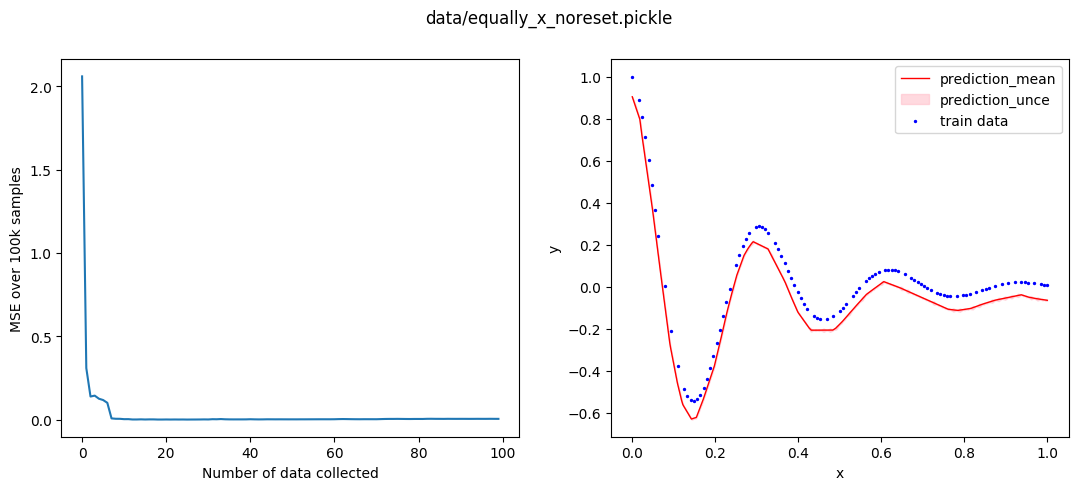

In [34]:
cand = 10000
device = torch.device("cuda:2")
model = EquallySpacedChoice(device)
eva = []
for i in range(100):
    x,y = get_data(target_function1,cand)
    x = x.to(device)
    y = y.to(device)
    max_id = model.pred_unce(x).argmax()
    if i ==0:
        train_x = x[max_id].view(1,1)
        train_y = y[max_id].view(1,1)
    else:
        train_x = torch.cat((train_x,x[max_id].view(1,1)))
        train_y = torch.cat((train_y,y[max_id].view(1,1)))
    #model = EquallySpacedChoice(device)
    model.learn(train_x,train_y)
    eva.append(eval_model(model))
save_name = 'data/'+model.name+'_noreset.pickle'
make_log(save_name,eva,train_x,train_y,model)
draw('data/'+model.name+'_noreset.pickle','data/'+model.name+'_noreset.png')

# EquallySpacedChoice in x,y
- TBI

In [10]:
MAX_TIME=10
MAX_ITR = 1000000
class EquallySpacedChoiceXY(AbstModel):
    def __init__(self,device,H=600,b_size=128):
        super().__init__(device)
        self.H = H
        self.b_size = b_size
        self.name = 'equally_xy'
        self.model = TwoLayerNetRes(1,H,1).to(self.device)
        self.optim = torch.optim.Adadelta(self.model.parameters())
        
    def pred_mean(self,x): # (10000)
        return self.model(x.unsqueeze(-1)).squeeze(1).detach() # (10000)

    def pred_unce(self,x):# (10000)
        if hasattr(self,'train_x'):
            y = self.model(x.unsqueeze(-1)).squeeze(1)
            ret = torch.zeros(x.shape)
            for i,(xx,yy) in enumerate(zip(x,y)):
                ret[i] = (torch.pow(self.train_x - xx,2)+torch.pow(self.train_y - yy,2)).min()
            return ret
        else:
            min_id = x.argmin()
            ret = torch.zeros(x.shape)
            ret[min_id]=1.0
            return  ret

    def learn(self,x,y):# (itr,1), (itr,1)
        st = time.time()
        for i in range(MAX_ITR):
            xx,yy = choice(x,y,self.b_size)
            y_ = yy.unsqueeze(-1)
            y_pred = self.model(xx.unsqueeze(-1))
            loss =torch.pow(y_pred-y_,2).mean()
            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
            if time.time() - st > MAX_TIME:
                break
        self.train_x = x
        self.train_y = y

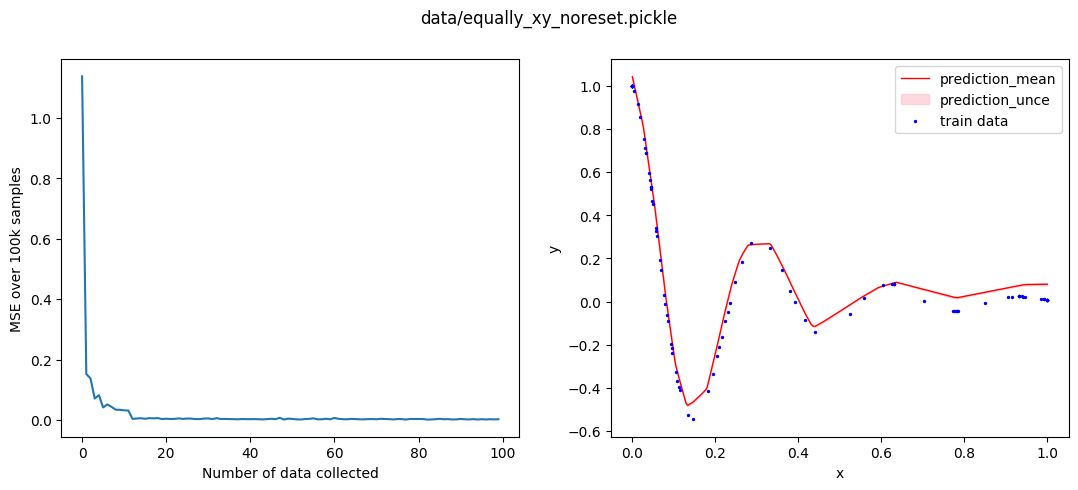

In [14]:
cand = 10000
device = torch.device("cuda:2")
model = EquallySpacedChoiceXY(device)
eva = []
for i in range(100):
    x,y = get_data(target_function1,cand)
    x = x.to(device)
    y = y.to(device)
    max_id = model.pred_unce(x).argmax()
    if i ==0:
        train_x = x[max_id].view(1,1)
        train_y = y[max_id].view(1,1)
    else:
        train_x = torch.cat((train_x,x[max_id].view(1,1)))
        train_y = torch.cat((train_y,y[max_id].view(1,1)))
    model = EquallySpacedChoiceXY(device)
    model.learn(train_x,train_y)
    eva.append(eval_model(model))
save_name = 'data/'+model.name+'_noreset.pickle'
make_log(save_name,eva,train_x,train_y,model)
draw('data/'+model.name+'_noreset.pickle','data/'+model.name+'_noreset.png')

# simple NN ensemble
- num_head models
- num_head optimizers

In [42]:
a = torch.rand(3)
torch.cat((a.view(3,1),a.view(3,1)),dim=1).mean(dim=1)

tensor([0.0851, 0.0368, 0.7566])

In [54]:
MAX_TIME=10
MAX_ITR = 1000000
class SimpleEnsembleModel(AbstModel):
    def __init__(self,device,num_head,H=600,b_size=128):
        super().__init__(device)
        self.H = H
        self.b_size = b_size
        self.num_head = num_head
        self.name = 'ensemble_of_'+str(num_head)
        self.models = [TwoLayerNetRes(1,H,1).to(self.device) for _ in range(self.num_head)]
        self.optims = [torch.optim.Adadelta(mo.parameters()) for mo in self.models]
        
    def pred_mean(self,x): # (10000)
        heads = torch.cat([mo(x.unsqueeze(-1)).detach() for mo in self.models],dim=1)
        return heads.mean(dim=1) # (10000)

    def pred_unce(self,x):# (10000)
        heads = torch.cat([mo(x.unsqueeze(-1)).detach() for mo in self.models],dim=1)
        return  heads.std(dim=1) # (10000)

    def learn(self,x,y):# (itr,1), (itr,1)
        for mo,op in zip(self.models,self.optims):
            st = time.time()
            for i in range(MAX_ITR):
                xx,yy = choice(x,y,self.b_size)
                y_ = yy.unsqueeze(-1)
                y_pred = mo(xx.unsqueeze(-1))
                loss =torch.pow(y_pred-y_,2).mean()
                op.zero_grad()
                loss.backward()
                op.step()
                if time.time() - st > MAX_TIME:
                    break

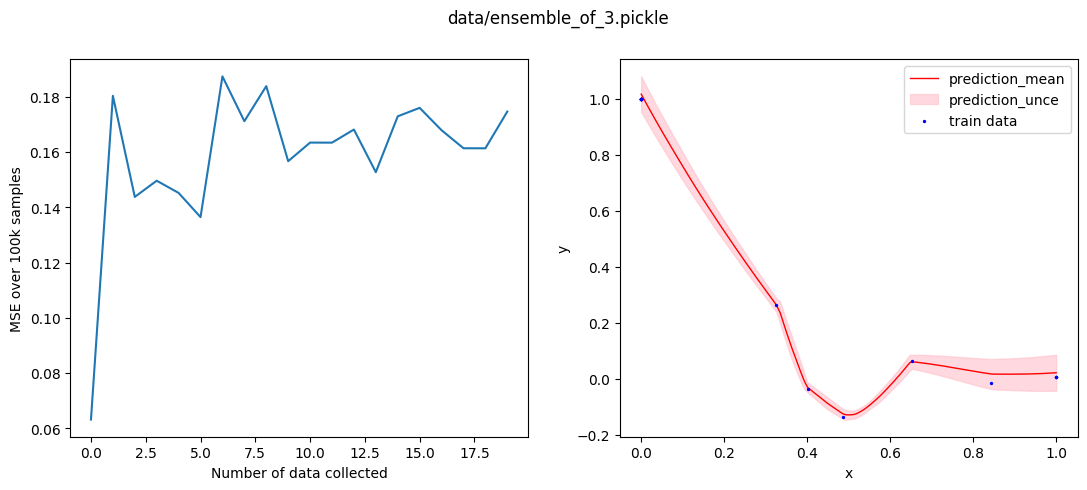

In [55]:
cand = 10000
num_head = 3
device = torch.device("cuda:2")
model = SimpleEnsembleModel(device,num_head)
eva = []
for i in range(20):
    x,y = get_data(target_function1,cand)
    x = x.to(device)
    y = y.to(device)
    max_id = model.pred_unce(x).argmax()
    if i ==0:
        train_x = x[max_id].view(1,1)
        train_y = y[max_id].view(1,1)
    else:
        train_x = torch.cat((train_x,x[max_id].view(1,1)))
        train_y = torch.cat((train_y,y[max_id].view(1,1)))
    model = SimpleEnsembleModel(device,num_head)
    model.learn(train_x,train_y)
    eva.append(eval_model(model))
save_name = 'data/'+model.name+'.pickle'
make_log(save_name,eva,train_x,train_y,model)
draw('data/'+model.name+'.pickle','data/'+model.name+'.png')

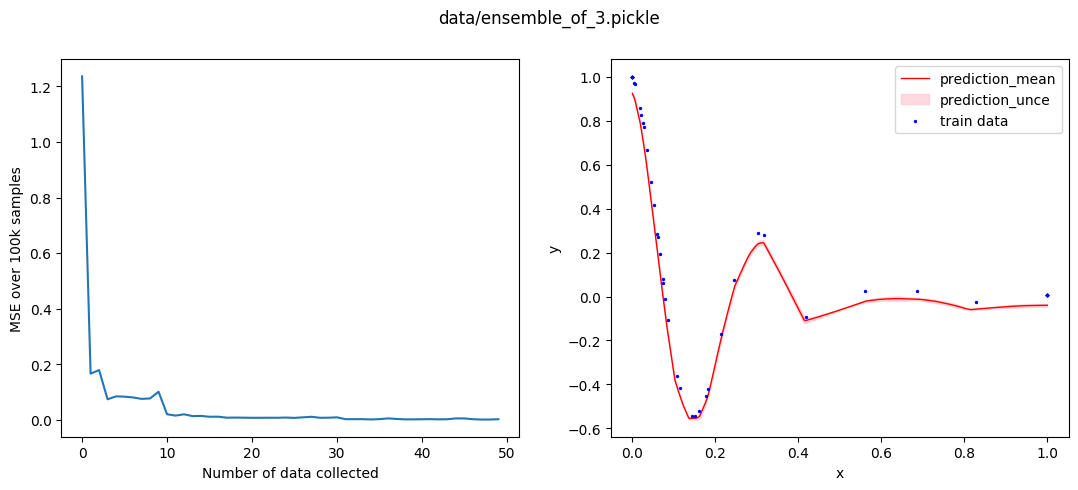

In [58]:
cand = 10000
num_head = 3
device = torch.device("cuda:2")
model = SimpleEnsembleModel(device,num_head)
eva = []
for i in range(50):
    x,y = get_data(target_function1,cand)
    x = x.to(device)
    y = y.to(device)
    max_id = model.pred_unce(x).argmax()
    if i ==0:
        train_x = x[max_id].view(1,1)
        train_y = y[max_id].view(1,1)
    else:
        train_x = torch.cat((train_x,x[max_id].view(1,1)))
        train_y = torch.cat((train_y,y[max_id].view(1,1)))
    model = SimpleEnsembleModel(device,num_head)
    model.learn(train_x,train_y)
    eva.append(eval_model(model))
save_name = 'data/'+model.name+'.pickle'
make_log(save_name,eva,train_x,train_y,model)
draw('data/'+model.name+'.pickle','data/'+model.name+'.png')

# simple NN ensemble with bootstrap
- trainに細工して，このheadの学習にはこれ使わないってやつをやりたい


In [64]:
MAX_TIME=10
MAX_ITR = 1000000

def choice_mod(x,y,N,m,n): #mod m != n
    idx = torch.randint(0,x.size(0),(2*N,))
    idx_mod = []
    while True:
        idx_mod += [ii for ii in idx if ii%m!=n]
        if len(idx_mod)>=N:
            break
        idx = torch.randint(0,x.size(0),(2*N,))
    idx = idx_mod[:N]
    return x[idx],y[idx]
    
class SimpleEnsembleModelBoot(AbstModel):
    def __init__(self,device,num_head,H=600,b_size=128):
        super().__init__(device)
        self.H = H
        self.b_size = b_size
        self.num_head = num_head
        self.name = 'ensemble_of_'+str(num_head)+'_boot'
        self.models = [TwoLayerNetRes(1,H,1).to(self.device) for _ in range(self.num_head)]
        self.optims = [torch.optim.Adadelta(mo.parameters()) for mo in self.models]
        
    def pred_mean(self,x): # (10000)
        heads = torch.cat([mo(x.unsqueeze(-1)).detach() for mo in self.models],dim=1)
        return heads.mean(dim=1) # (10000)

    def pred_unce(self,x):# (10000)
        heads = torch.cat([mo(x.unsqueeze(-1)).detach() for mo in self.models],dim=1)
        return  heads.std(dim=1) # (10000)

    def learn(self,x,y):# (itr,1), (itr,1)
        for j, (mo,op) in enumerate(zip(self.models,self.optims)):
            if len(x)==1 and j==0:
                break
            st = time.time()
            for i in range(MAX_ITR):
                xx,yy = choice_mod(x,y,self.b_size,self.num_head,j)
                y_ = yy.unsqueeze(-1)
                y_pred = mo(xx.unsqueeze(-1))
                loss =torch.pow(y_pred-y_,2).mean()
                op.zero_grad()
                loss.backward()
                op.step()
                if time.time() - st > MAX_TIME:
                    break

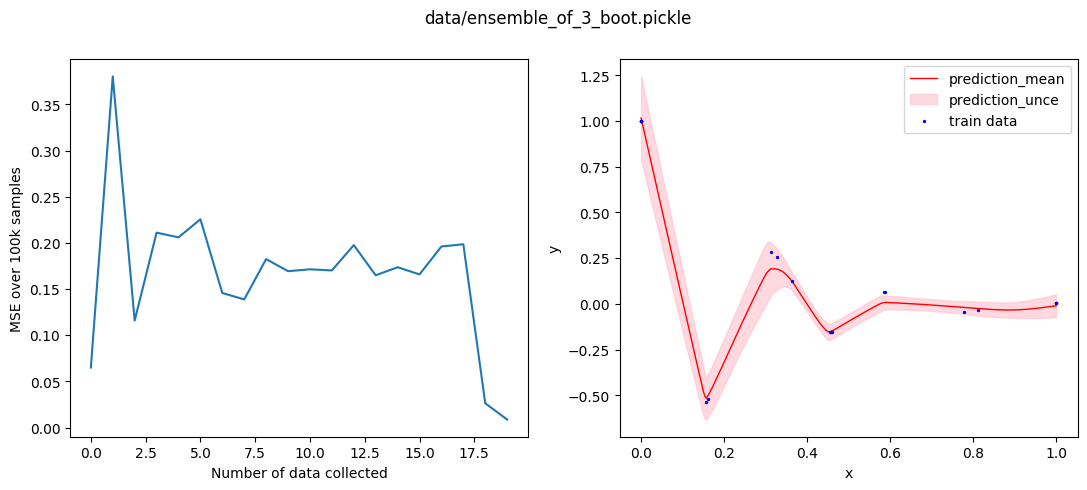

In [67]:
cand = 10000
num_head = 3
device = torch.device("cuda:2")
model = SimpleEnsembleModelBoot(device,num_head)
eva = []
for i in range(20):
    x,y = get_data(target_function1,cand)
    x = x.to(device)
    y = y.to(device)
    max_id = model.pred_unce(x).argmax()
    if i ==0:
        train_x = x[max_id].view(1,1)
        train_y = y[max_id].view(1,1)
    else:
        train_x = torch.cat((train_x,x[max_id].view(1,1)))
        train_y = torch.cat((train_y,y[max_id].view(1,1)))
    model = SimpleEnsembleModelBoot(device,num_head)
    model.learn(train_x,train_y)
    eva.append(eval_model(model))
save_name = 'data/'+model.name+'.pickle'
make_log(save_name,eva,train_x,train_y,model)
draw('data/'+model.name+'.pickle','data/'+model.name+'.png')

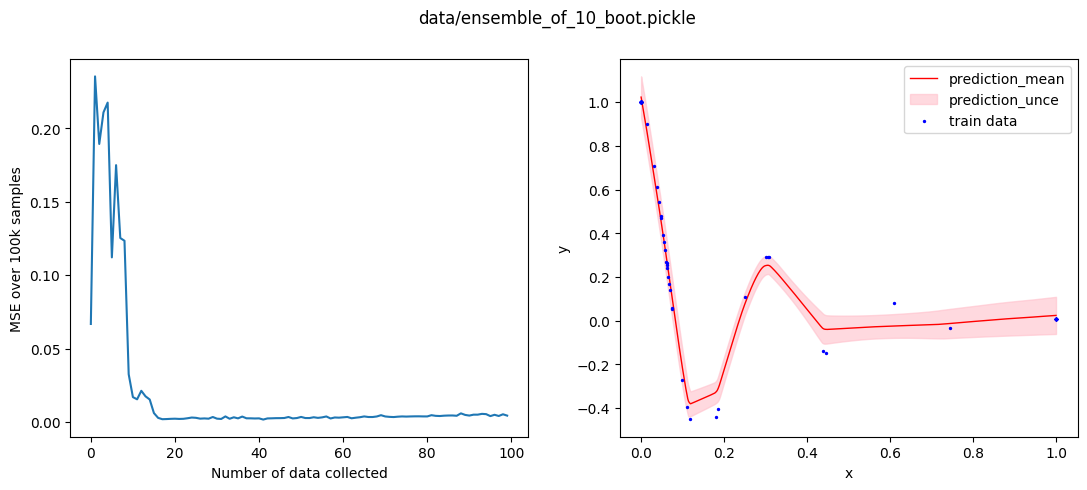

In [66]:
cand = 10000
num_head = 10
device = torch.device("cuda:2")
model = SimpleEnsembleModelBoot(device,num_head)
eva = []
for i in range(100):
    x,y = get_data(target_function1,cand)
    x = x.to(device)
    y = y.to(device)
    max_id = model.pred_unce(x).argmax()
    if i ==0:
        train_x = x[max_id].view(1,1)
        train_y = y[max_id].view(1,1)
    else:
        train_x = torch.cat((train_x,x[max_id].view(1,1)))
        train_y = torch.cat((train_y,y[max_id].view(1,1)))
    model = SimpleEnsembleModelBoot(device,num_head)
    model.learn(train_x,train_y)
    eva.append(eval_model(model))
save_name = 'data/'+model.name+'.pickle'
make_log(save_name,eva,train_x,train_y,model)
draw('data/'+model.name+'.pickle','data/'+model.name+'.png')

# QRNN
- one model predict all quantiles
- unce was defined by entropy $\log(abcd)$
- center:= learned by L1 original loss
- other quantile is representated by 

In [15]:
MAX_TIME=20
MAX_ITR = 1000000
MIN_WIDTH = 1e-6
class QRNNModel(AbstModel):
    def __init__(self,device,num_head,H=600,b_size=128):
        super().__init__(device)
        self.H = H
        self.device=device
        self.b_size = b_size
        assert num_head%2!=0, 'even number'
        self.quantiles = torch.tensor(
            [i/(num_head+1) for i in range(1,num_head+1)],dtype=torch.float).to(device)
        self.num_head = num_head
        self.name = 'qrnn_of_'+str(num_head)
        self.model = TwoLayerNetRes(1,H,num_head).to(self.device) # (10000,num_head)
        self.optim = torch.optim.Adadelta(self.model.parameters())
        self.center_id = int(num_head/2)
        # make q_head
        width = int((num_head-1)/2)
        self.q_head = torch.zeros((num_head,num_head),dtype=torch.float).to(device)
        self.q_head[self.center_id,:] = 1
        for i in range(0,width):
            self.q_head[i,:i+1] = 1
            self.q_head[num_head-i-1,num_head-i-1:] = 1
        self.q_head = self.q_head.to(device)
                              
    def pred_quantile(self,x):# (10000)
        model_out = self.model(x.unsqueeze(-1)).squeeze(1) # (10000,num_head)
        #l = model_out[:,:self.center_id].clamp(min=MIN_WIDTH)
        l = model_out[:,:self.center_id].abs() + MIN_WIDTH
        m = model_out[:,self.center_id].unsqueeze(-1)
        r = model_out[:,self.center_id+1:].abs() + MIN_WIDTH
        #r = model_out[:,self.center_id+1:].clamp(min=MIN_WIDTH)
        return torch.cat((-1*l,m,r),dim=1)@self.q_head #(10000,num_head)                
        
    def pred_mean(self,x): # (10000)
        model_out = self.model(x.unsqueeze(-1)).squeeze(1)
        return (model_out[:,self.center_id].detach()) # (10000)

    def pred_unce(self,x):# (10000)
        model_out = self.model(x.unsqueeze(-1)).squeeze(1)
        l = model_out[:,:self.center_id].abs() + MIN_WIDTH
        r = model_out[:,self.center_id+1:].abs() + MIN_WIDTH
        aa = torch.log(torch.cat((l,r),dim=1))
        bb = torch.log(MIN_WIDTH*torch.ones(1,dtype=torch.float)).to(self.device)
        a = (aa-bb).sum(dim=1)
        return a/100 # (10000)

    def learn(self,x,y):# (itr,1), (itr,1)
        st = time.time()
        for i in range(MAX_ITR):
            xx,yy = choice(x,y,self.b_size)
            quan_out = self.pred_quantile(xx)
            error = (yy.expand(yy.shape[0],self.num_head) - quan_out)
            #print(error)
            loss = torch.max(error* self.quantiles ,error*(self.quantiles -1)).sum()
            self.optim.zero_grad()
            loss.backward()
            #print(loss.item())
            self.optim.step()
            if time.time() - st > MAX_TIME:
                break

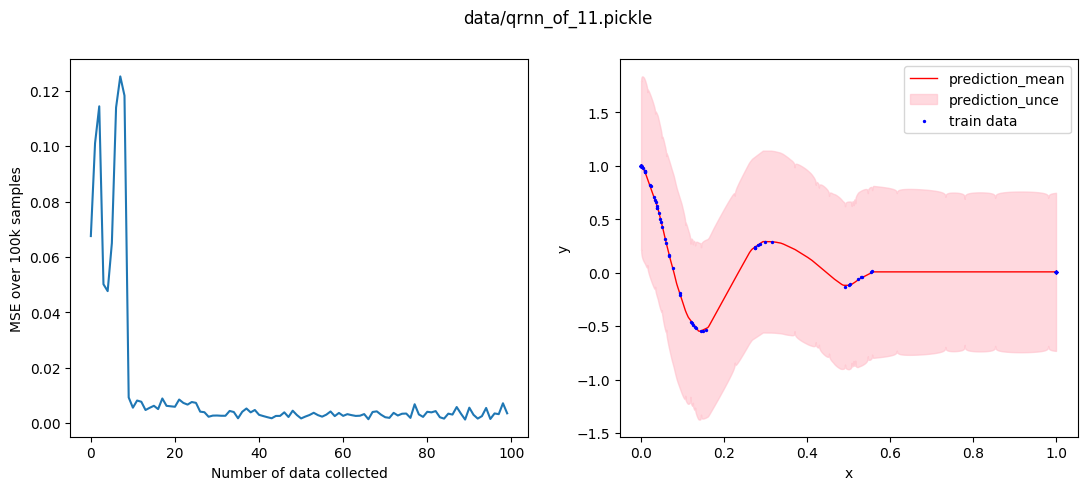

In [16]:
cand = 10000
num_head = 11
device = torch.device("cuda:2")
model = QRNNModel(device,num_head)
eva = []
for i in range(100):
    x,y = get_data(target_function1,cand)
    x = x.to(device)
    y = y.to(device)
    max_id = model.pred_unce(x).argmax()
    if i ==0:
        train_x = x[max_id].view(1,1)
        train_y = y[max_id].view(1,1)
    else:
        train_x = torch.cat((train_x,x[max_id].view(1,1)))
        train_y = torch.cat((train_y,y[max_id].view(1,1)))
    model = QRNNModel(device,num_head)
    model.learn(train_x,train_y)
    eva.append(eval_model(model))
save_name = 'data/'+model.name+'.pickle'
make_log(save_name,eva,train_x,train_y,model)
draw('data/'+model.name+'.pickle','data/'+model.name+'.png')

# Discriminator(negative = already generated data)
- uncertainty is defined by generaterness

In [32]:
MAX_TIME=10
MAX_ITR = 1000000
EPS=1e-7
class DiscrimModel(AbstModel):
    def __init__(self,device,H=600,b_size=128):
        super().__init__(device)
        self.H = H
        self.b_size = b_size
        self.num_head = num_head
        self.name = 'discrim_model'
        self.model = TwoLayerNetRes(1,H,1).to(self.device)
        self.discrim = TwoLayerNetRes(2,H,1).to(self.device) # gene =1, real=0
        self.optim = torch.optim.Adadelta(self.model.parameters())
        self.optim_discrim = torch.optim.Adadelta(self.discrim.parameters())
        
    def pred_mean(self,x): # (10000)
        return self.model(x.unsqueeze(-1)).squeeze(1).detach() # (10000)
    
    def discriminate(self,xy): #(10000,2)
         return 1/(1+torch.exp(-self.discrim(xy))) # sigmoid,(10000,1)

    def pred_unce(self,x):# (10000)
        y = self.model(x.unsqueeze(-1)).detach()
        xy = torch.cat((x.unsqueeze(-1),y),dim=1)
        if hasattr(self, 'gene_xy'):
            self.gene_xy = torch.cat((self.gene_xy,xy))
        else:
            self.gene_xy = xy
        return self.discriminate(xy).squeeze(1) # (10000)

    def learn(self,x,y):# (itr,1), (itr,1)
        st = time.time()
        # learn model
        for i in range(MAX_ITR):
            xx,yy = choice(x,y,self.b_size)
            y_ = yy.unsqueeze(-1)
            y_pred = self.model(xx.unsqueeze(-1))
            loss =torch.pow(y_pred-y_,2).mean()
            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
            #print(loss.item())
            if time.time() - st > MAX_TIME:
                break
        st = time.time()
        # learn discrim
        for i in range(MAX_ITR):
            d_y1 = torch.ones(int(self.b_size/2),dtype=torch.float).to(self.device)
            d_x1 = self.gene_xy[torch.randint(0,self.gene_xy.shape[0],(int(self.b_size/2),))]
            
            d_xx,d_yy = choice(x,y,int(self.b_size/2))
            d_x2 = torch.cat((d_xx,d_yy),dim=1)
            d_y2 = torch.zeros(int(self.b_size/2),dtype=torch.float).to(self.device)
            d_y1pred = self.discriminate(d_x1).squeeze(1) #ret (10000,1)
            d_y2pred = self.discriminate(d_x2).squeeze(1)
            # BCE
            loss_discrim =(-d_y1*torch.log(d_y1pred.clamp(min=EPS))\
                                  -(1-d_y1)*torch.log((1-d_y2pred).clamp(min=EPS))\
                                  -d_y2*torch.log(d_y2pred.clamp(min=EPS))\
                                  -(1-d_y2)*torch.log(1-d_y2pred).clamp(min=EPS)).mean()
            self.optim_discrim.zero_grad()
            loss_discrim.backward()
            #print('dis',loss_discrim.item())
            self.optim_discrim.step()
            if time.time() - st > MAX_TIME/2:
                break

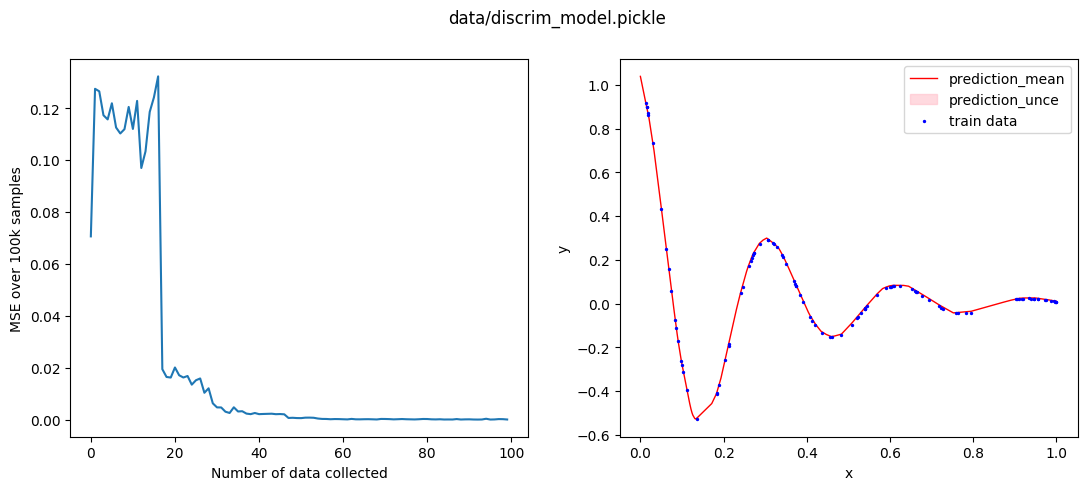

In [33]:
cand = 10000
device = torch.device("cuda:2")
model = DiscrimModel(device)
eva = []
for i in range(100):
    x,y = get_data(target_function1,cand)
    x = x.to(device)
    y = y.to(device)
    max_id = model.pred_unce(x).argmax()
    if i ==0:
        train_x = x[max_id].view(1,1)
        train_y = y[max_id].view(1,1)
    else:
        train_x = torch.cat((train_x,x[max_id].view(1,1)))
        train_y = torch.cat((train_y,y[max_id].view(1,1)))
    model.learn(train_x,train_y)
    eva.append(eval_model(model))
save_name = 'data/'+model.name+'.pickle'
make_log(save_name,eva,train_x,train_y,model)
draw('data/'+model.name+'.pickle','data/'+model.name+'.png')

# Discriminator(nagative=normal distribution)
- uncertainty is defined by generaterness

In [41]:
MAX_TIME=10
MAX_ITR = 1000000
EPS=1e-7
class DiscrimModelNormal(AbstModel):
    def __init__(self,device,H=600,b_size=128):
        super().__init__(device)
        self.H = H
        self.b_size = b_size
        self.num_head = num_head
        self.name = 'discrim_model_normal'
        self.model = TwoLayerNetRes(1,H,1).to(self.device)
        self.discrim = TwoLayerNetRes(2,H,1).to(self.device) # gene =1, real=0
        self.optim = torch.optim.Adadelta(self.model.parameters())
        self.optim_discrim = torch.optim.Adadelta(self.discrim.parameters())
        
    def pred_mean(self,x): # (10000)
        return self.model(x.unsqueeze(-1)).squeeze(1).detach() # (10000)
    
    def discriminate(self,xy): #(10000,2)
         return 1/(1+torch.exp(-self.discrim(xy))) # sigmoid,(10000,1)

    def pred_unce(self,x):# (10000)
        y = self.model(x.unsqueeze(-1)).detach()
        xy = torch.cat((x.unsqueeze(-1),y),dim=1)
        if hasattr(self, 'gene_xy'):
            self.gene_xy = torch.cat((self.gene_xy,xy))
        else:
            self.gene_xy = xy
        return self.discriminate(xy).squeeze(1)*100 # (10000)

    def learn(self,x,y):# (itr,1), (itr,1)
        st = time.time()
        # learn model
        for i in range(MAX_ITR):
            xx,yy = choice(x,y,self.b_size)
            y_ = yy.unsqueeze(-1)
            y_pred = self.model(xx.unsqueeze(-1))
            loss =torch.pow(y_pred-y_,2).mean()
            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
            #print(loss.item())
            if time.time() - st > MAX_TIME:
                break
        st = time.time()
        # learn discrim
        for i in range(MAX_ITR):
            d_y1 = torch.ones(int(self.b_size/2),dtype=torch.float).to(self.device)
            
            # normal distribution
            nx = (torch.randn((int(self.b_size/2),1))*x.std()+x.mean()).to(self.device)
            ny = (torch.randn((int(self.b_size/2),1))*y.std()+y.mean()).to(self.device)
            d_x1 = torch.cat((nx,ny),dim=1)
            #d_x1 = self.gene_xy[torch.randint(0,self.gene_xy.shape[0],(int(self.b_size/2),))]
            
            d_xx,d_yy = choice(x,y,int(self.b_size/2))
            d_x2 = torch.cat((d_xx,d_yy),dim=1)
            d_y2 = torch.zeros(int(self.b_size/2),dtype=torch.float).to(self.device)
            d_y1pred = self.discriminate(d_x1).squeeze(1) #ret (10000,1)
            d_y2pred = self.discriminate(d_x2).squeeze(1)
            # BCE
            loss_discrim =(-d_y1*torch.log(d_y1pred.clamp(min=EPS))\
                                  -(1-d_y1)*torch.log((1-d_y2pred).clamp(min=EPS))\
                                  -d_y2*torch.log(d_y2pred.clamp(min=EPS))\
                                  -(1-d_y2)*torch.log(1-d_y2pred).clamp(min=EPS)).mean()
            self.optim_discrim.zero_grad()
            loss_discrim.backward()
            #print('dis',loss_discrim.item())
            self.optim_discrim.step()
            if time.time() - st > MAX_TIME/2:
                break

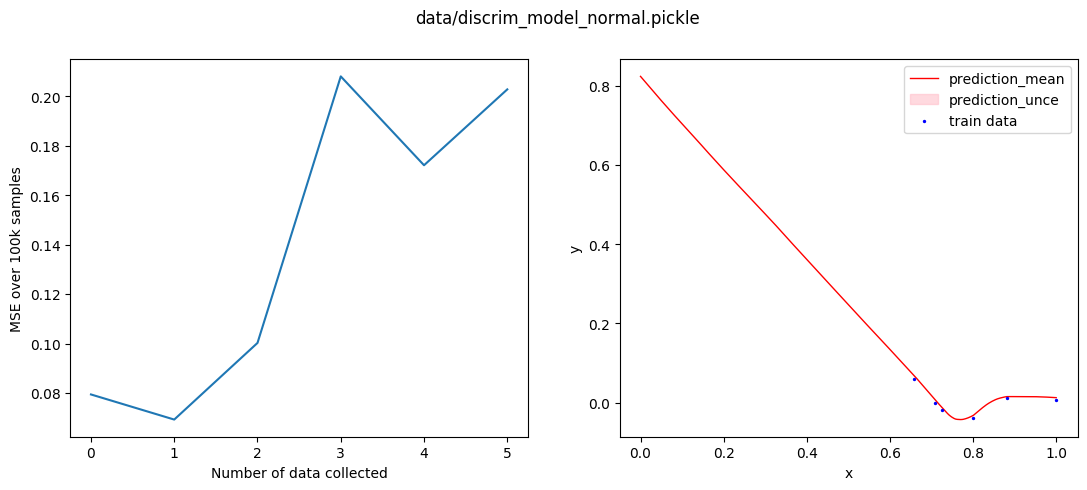

In [42]:
cand = 10000
device = torch.device("cuda:2")
model = DiscrimModelNormal(device)
eva = []
for i in range(6):
    x,y = get_data(target_function1,cand)
    x = x.to(device)
    y = y.to(device)
    max_id = model.pred_unce(x).argmax()
    if i ==0:
        train_x = x[max_id].view(1,1)
        train_y = y[max_id].view(1,1)
    else:
        train_x = torch.cat((train_x,x[max_id].view(1,1)))
        train_y = torch.cat((train_y,y[max_id].view(1,1)))
    model.learn(train_x,train_y)
    eva.append(eval_model(model))
save_name = 'data/'+model.name+'.pickle'
make_log(save_name,eva,train_x,train_y,model)
draw('data/'+model.name+'.pickle','data/'+model.name+'.png')

### show qrnn

In [24]:
from IPython import display
from IPython.display import clear_output

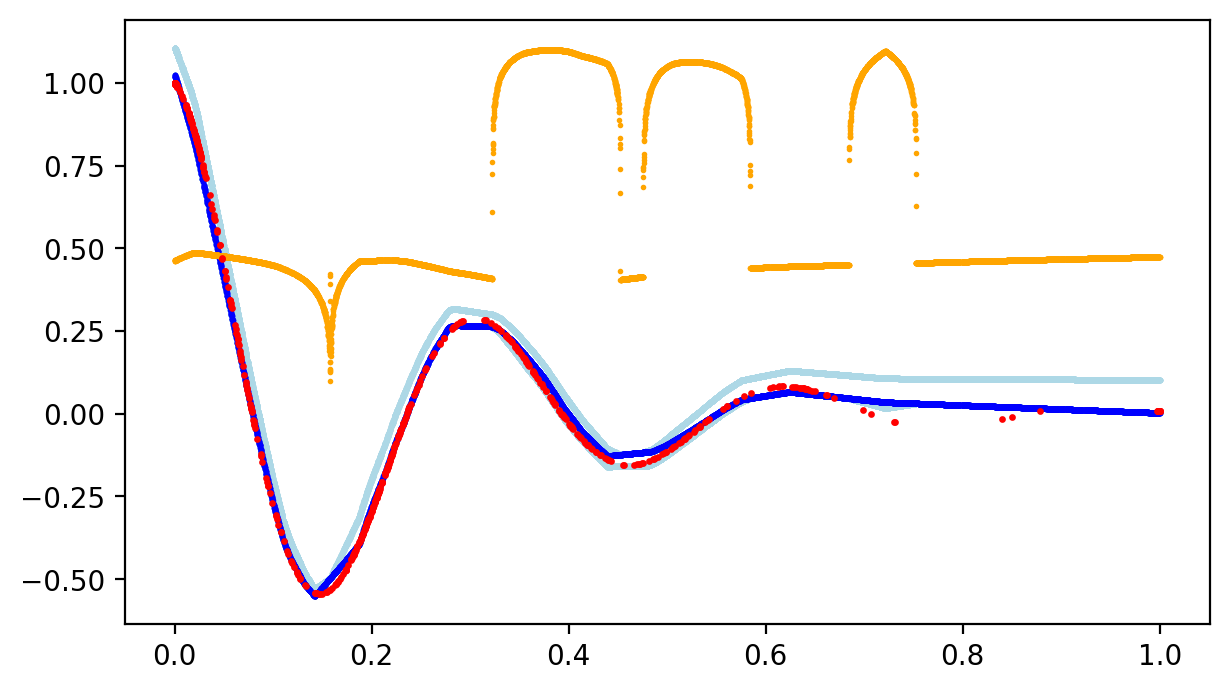

iteration: 579	

In [ ]:
cand = 1000
fn = target_function1
device = torch.device("cuda:1")
num_head=11
model = QRNNModel(device,num_head)

for i in range(1000):
    print('iteration:',i,end='\t')
    x,y = get_data(fn,cand) # (10000),(10000)
    x = x.to(device)
    max_id = model.pred_unce(x).argmax()
    if i == 0:
        train_data_x = x[max_id].view(1,1) 
        train_data_y = fn(x[max_id]).view(1,1)
    else:
        train_data_x = torch.cat((train_data_x,x[max_id].view(1,1))) # (i,1) -> (i+1)
        train_data_y = torch.cat((train_data_y,fn(x[max_id]).view(1,1)))
    model = QRNNModel(device,num_head)
    model.learn(train_data_x,train_data_y)
    
    # plot
    clear_output(wait=True)
    plt.figure(figsize=(7,4),dpi=200)
    x, y = get_data(target_function1,10000)
    x = x.to(device)
    y = y.to(device)
    y_hat = model.pred_quantile(x)
    for i in range(num_head):
        plt.scatter(nm(x),nm(y_hat)[:,i],s=1,c='lightblue')
    plt.scatter(nm(x),nm(model.pred_mean(x)),s=1,c='blue')
    unc = nm(model.pred_unce(x))
    plt.scatter(nm(x),(unc-unc.min())/(unc.max()-unc.min())+0.1,s=1,c='orange')
    # plt.scatter(nm(x),nm(y),s=1,alpha=0.01,c='pink')
    plt.scatter(nm(train_data_x),nm(train_data_y),s = 2,color='red')
    plt.pause(0.05)

# ====== Legacy ======

## Pseudo code (Animaton!!)

In [208]:
from IPython import display
from IPython.display import clear_output

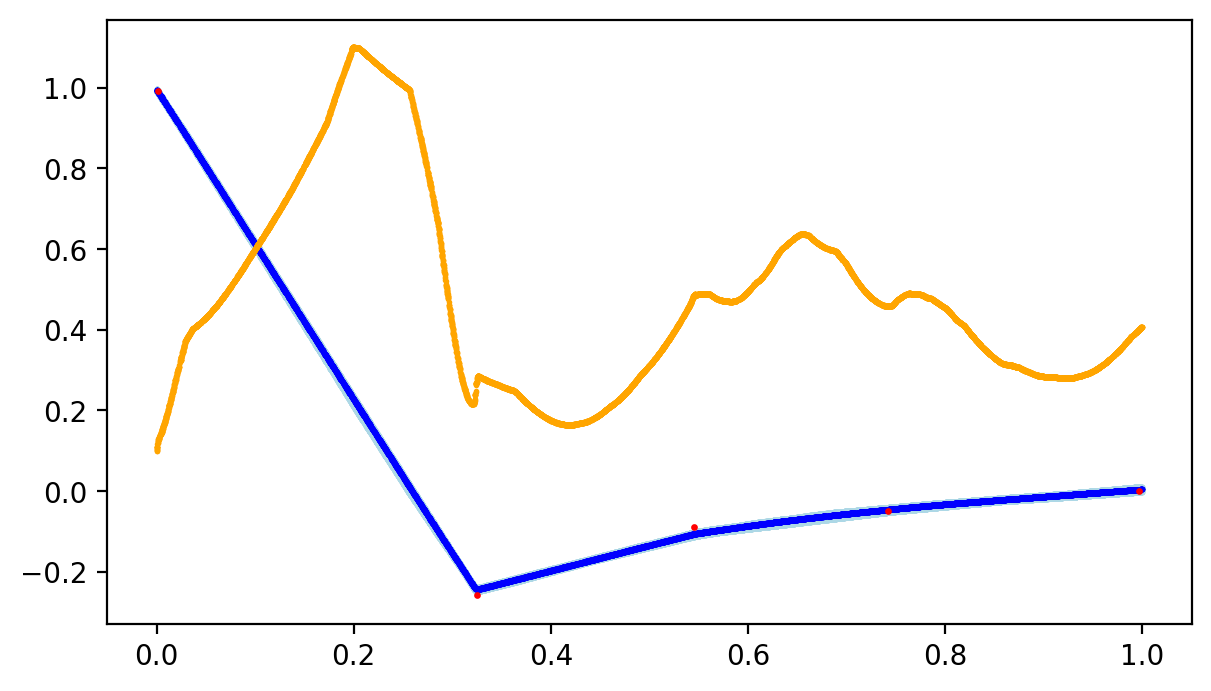

iteration: 5	

KeyboardInterrupt: 

In [90]:
cand = 1000
fn = target_function1
device = torch.device("cuda:1")
num_head=10
th = 0.0001
H = 100
model = Multihead_EnsembleRes(num_head,device,to_next_th=th,H=H)

for i in range(1000):
    print('iteration:',i,end='\t')
    x,y = get_data(fn,cand) # (10000),(10000)
    x = x.to(device)
    max_id = model.pred_unce(x).argmax()
    if i == 0:
        train_data_x = x[max_id].view(1,1) 
        train_data_y = fn(x[max_id]).view(1,1)
    else:
        train_data_x = torch.cat((train_data_x,x[max_id].view(1,1))) # (i,1) -> (i+1)
        train_data_y = torch.cat((train_data_y,fn(x[max_id]).view(1,1)))
    model = Multihead_Ensemble(num_head,device,to_next_th=th,H=H)
    model.learn(train_data_x,train_data_y)
    
    # plot
    clear_output(wait=True)
    plt.figure(figsize=(7,4),dpi=200)
    x, y = get_data(target_function1,10000)
    x = x.to(device)
    y = y.to(device)
    y_hat = model.pred(x)
    for i in range(num_head):
        plt.scatter(nm(x),nm(y_hat)[:,i],s=1,c='lightblue')
    plt.scatter(nm(x),nm(model.pred_mean(x)),s=1,c='blue')
    unc = nm(model.pred_unce(x))
    plt.scatter(nm(x),(unc-unc.min())/(unc.max()-unc.min())+0.1,s=1,c='orange')
    # plt.scatter(nm(x),nm(y),s=1,alpha=0.01,c='pink')
    plt.scatter(nm(train_data_x),nm(train_data_y),s = 2,color='red')
    plt.pause(0.05)